# Unsupervised Learning On Images


Use this notebook to train an unsupervised learning algorithm to classify images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

### Load Data

In [2]:
# Load the Olivetti dataset

olivetti_dataset = fetch_olivetti_faces()
print(olivetti_dataset.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [3]:
olivetti_dataset.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

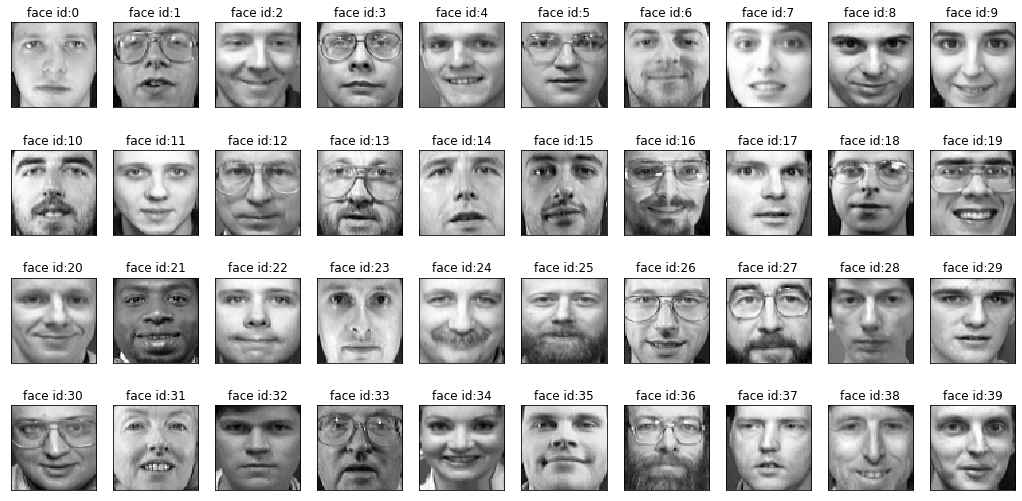

In [4]:
# plot a sample image for each of the 40 classes

images = olivetti_dataset.images 

fig = plt.figure(figsize=(18,9)) 

for unique_id in range(40): 
    image_index = unique_id*10
    img_grid = fig.add_subplot(4, 10,  unique_id+1)
    img_grid.imshow(images[image_index], cmap='gray')
    img_grid.set_xticks([])
    img_grid.set_yticks([])
    img_grid.set_title("face id:{}".format(unique_id))

plt.show()


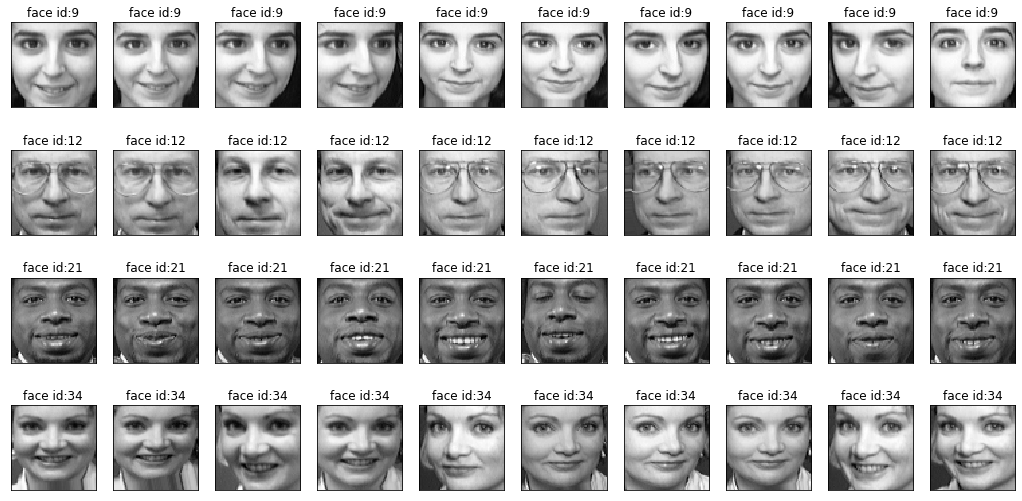

In [5]:
# plot all the 10 faces for 4 classes

fig = plt.figure(figsize=(18,9)) 
spec = fig.add_gridspec(ncols=10, nrows=4)

for i, class_id in enumerate([9, 12, 21, 34]): 
    for j in range(10):
        image_index = class_id*10 + j 
        img_grid = fig.add_subplot(spec[i, j])
        img_grid.imshow(images[image_index], cmap='gray')
        img_grid.set_xticks([])
        img_grid.set_yticks([])
        img_grid.set_title("face id:{}".format(class_id))

plt.show()

### Splitting data

In [6]:
# split data into train, test, validation sets using stratified sampling
# this will ensure there are the same number of images per class/person

# train/val split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=120, random_state=42)
train_idx, val_idx = next(strat_split.split(olivetti_dataset.data, olivetti_dataset.target))

X_train = olivetti_dataset.data[train_idx]
y_train = olivetti_dataset.target[train_idx]

X_val = olivetti_dataset.data[val_idx]
y_val = olivetti_dataset.target[val_idx]

# test/val split
strat_split2 = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
test_idx, valid_idx = next(strat_split2.split(X_val, y_val))

X_test = X_val[test_idx]
y_test = y_val[test_idx]

X_valid = X_val[valid_idx]
y_valid = y_val[valid_idx]


In [7]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


## Reduce dimensionality - PCA

To speed up the algorithm training, we are going to reduce the dataset dimensionality using PCA (Principal Component Analysis)

PCA is a dimensionality reduction algorithm that allows to represent data with fewer dimension: data are tranformed into new components, and the most important ones are selected.

How to choose the right number of dimensions? We are going to choose the number of dimensions that preserves a large portion of the variance, 95% in our case. 

Firstly, we perform PCA without reducing dimensionality (i.e. withouth selecting the number of dimensions), then we are going to use the _explained variance ratio_ to understand the proportion of the dataset's variance associated to each principal component, and compute the number of dimensions required to preserve 95% of the variance (in the training dataset).

In [8]:
pca_d = PCA()
pca_d.fit(X_train)
cumsum = np.cumsum(pca_d.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)+1
print(d)

104


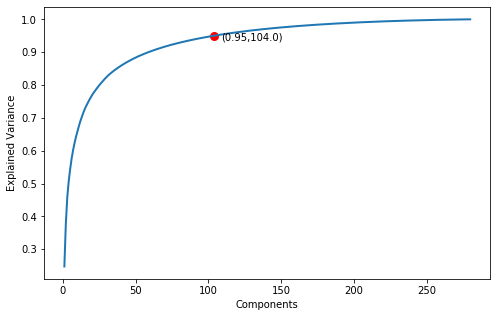

In [9]:
# plot the explained variance as number of dimension

# interpolate y=.95 with the cumsum curve
interp = np.ceil(np.interp(0.95, cumsum, range(1,len(cumsum)+1)))

# dimensions
dims = range(1,len(cumsum)+1)

# txt coords
txt = '(0.95,'+str(interp)+')' 

plt.figure(1, figsize=(8,5))

plt.plot(dims, cumsum, linewidth=2)
plt.scatter(y=.95, x=interp, color='r', linewidths=3)
plt.annotate(txt, (interp+5, 0.95-0.015))

plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.show()

It looks like that 104 is the  number of dimensions to choose. Let's now define pca using this number of dimensions: either setting n_components=104 or n_components=0.95.

In [10]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

104

## Unsupervised Learning

We'll use 2 unsupervised clustering task: K-Means and Gaussian Mixture. For each of them, we will visualise the clusters obtained using the functions below.

In [11]:
# functions to visualise clusters

# plot the images
def plot_images(images, labels, n_cols=10):
    images = images.reshape(-1, 64, 64)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()
    
def visualise_clusters(model, X, y):
    for cl_id in np.unique(model.labels_):
        print("Cluster "+str(cl_id+1))
        in_cluster_idxs = model.labels_ == cl_id
        images = X[in_cluster_idxs]
        labels = y[in_cluster_idxs]
        plot_images(images, labels)

In [12]:
# functions to plot silhoutte scores and inertia for K-means

def compute_silhouette_scores(X, model_array, param_range):
    silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in model_array]
    
    best_idx = np.argmax(silhouette_scores) # idx where score is max
    best_param = param_range[best_idx] 
    best_score = silhouette_scores[best_idx]
    return silhouette_scores, best_idx, best_param, best_score

def compute_inertia(X, model_array, param_range):
    silhouette_scores, best_idx, best_param, best_score = compute_silhouette_scores(X, model_array, param_range)
    inertias = [model.inertia_ for model in model_array]
    best_inertia = inertias[best_idx]
    return inertias, best_inertia, best_param



def plot_silhouette(X, model_array, param_range, param_label):
    silhouette_scores, best_idx, best_param, best_score = compute_silhouette_scores(X, model_array, param_range)
    plt.figure(figsize=(8, 3))

    plt.plot(param_range, silhouette_scores, "o-")
    plt.plot(best_param, best_score, "rs")

    plt.xlabel(param_label)
    plt.ylabel("Silhouette score")
    plt.annotate('Best ' + param_label+ ': ' +str(best_param), (best_param, best_score-0.05), fontsize=14)

    plt.show()
    
    
    
def plot_inertia(X, model_array, param_range, param_label):
    inertias, best_inertia, best_param = compute_inertia(X, model_array, param_range)
    plt.figure(figsize=(8, 3.5))

    plt.plot(param_range, inertias, "o-")
    plt.plot(best_param, best_inertia, "rs")

    plt.xlabel(param_label, fontsize=14)
    plt.ylabel("Inertia", fontsize=14)

    plt.annotate('Best ' + param_label+ ': ' +str(best_param), (best_param, best_inertia+1000), fontsize=14)

    plt.show()    

### K-Means

In [13]:
# cluster images using K-means

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

Use silhouette scores and inertia to pick the best number of clusters.

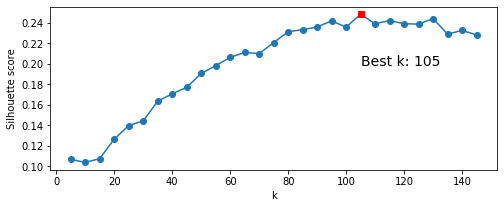

In [14]:
plot_silhouette(X_train_pca, kmeans_per_k, k_range, 'k')

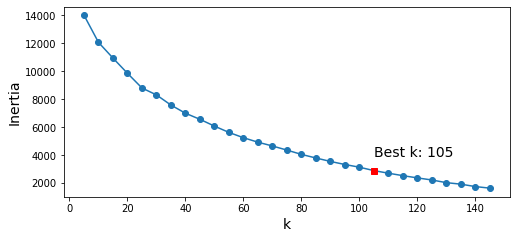

In [15]:
plot_inertia(X_train_pca, kmeans_per_k, k_range, 'k')

The silhoutte score seems to suggest that the best number of clusters is 105. This is not exactly clear from the inertia plot, since there is not a clear "elbow", an inflexion point showing the k value for which the inertia decrease more slowly.
For the rest, we are going to choose **k=105**.

Cluster 1


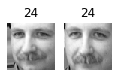

Cluster 2


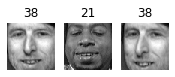

Cluster 3


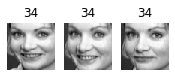

Cluster 4


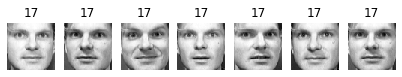

Cluster 5


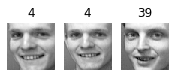

Cluster 6


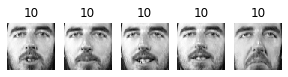

Cluster 7


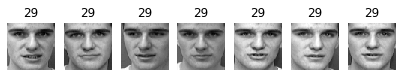

Cluster 8


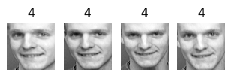

Cluster 9


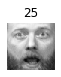

Cluster 10


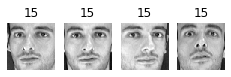

Cluster 11


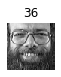

Cluster 12


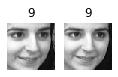

Cluster 13


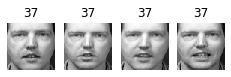

Cluster 14


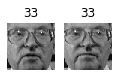

Cluster 15


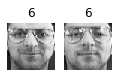

Cluster 16


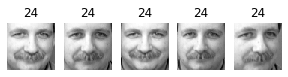

Cluster 17


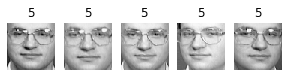

Cluster 18


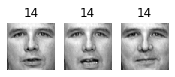

Cluster 19


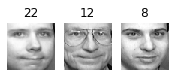

Cluster 20


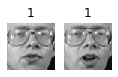

Cluster 21


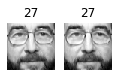

Cluster 22


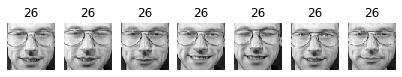

Cluster 23


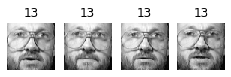

Cluster 24


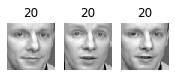

Cluster 25


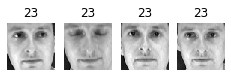

Cluster 26


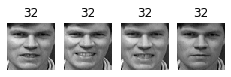

Cluster 27


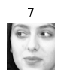

Cluster 28


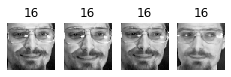

Cluster 29


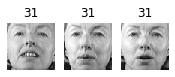

Cluster 30


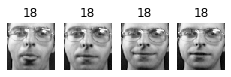

Cluster 31


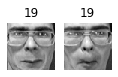

Cluster 32


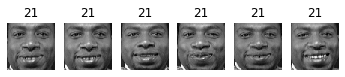

Cluster 33


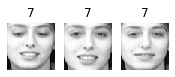

Cluster 34


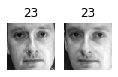

Cluster 35


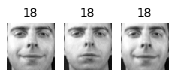

Cluster 36


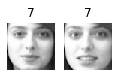

Cluster 37


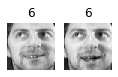

Cluster 38


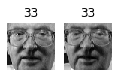

Cluster 39


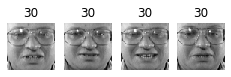

Cluster 40


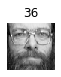

Cluster 41


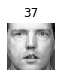

Cluster 42


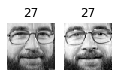

Cluster 43


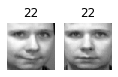

Cluster 44


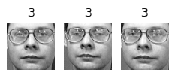

Cluster 45


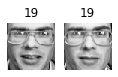

Cluster 46


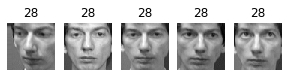

Cluster 47


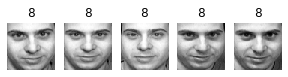

Cluster 48


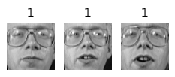

Cluster 49


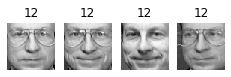

Cluster 50


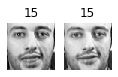

Cluster 51


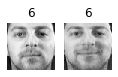

Cluster 52


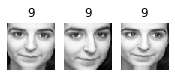

Cluster 53


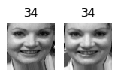

Cluster 54


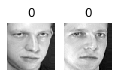

Cluster 55


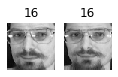

Cluster 56


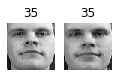

Cluster 57


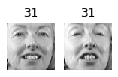

Cluster 58


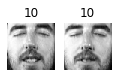

Cluster 59


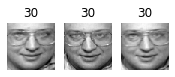

Cluster 60


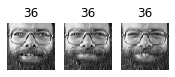

Cluster 61


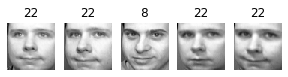

Cluster 62


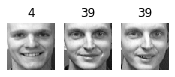

Cluster 63


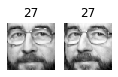

Cluster 64


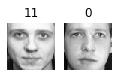

Cluster 65


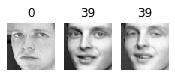

Cluster 66


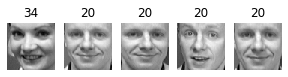

Cluster 67


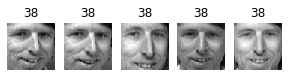

Cluster 68


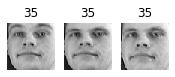

Cluster 69


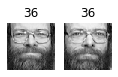

Cluster 70


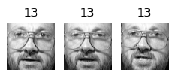

Cluster 71


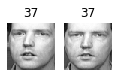

Cluster 72


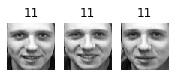

Cluster 73


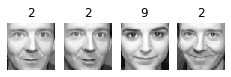

Cluster 74


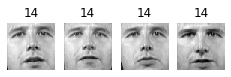

Cluster 75


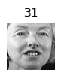

Cluster 76


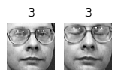

Cluster 77


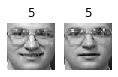

Cluster 78


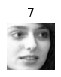

Cluster 79


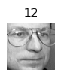

Cluster 80


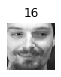

Cluster 81


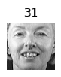

Cluster 82


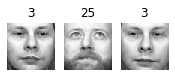

Cluster 83


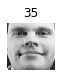

Cluster 84


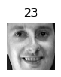

Cluster 85


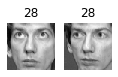

Cluster 86


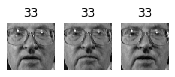

Cluster 87


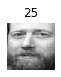

Cluster 88


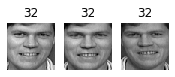

Cluster 89


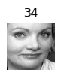

Cluster 90


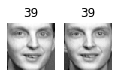

Cluster 91


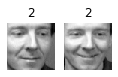

Cluster 92


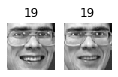

Cluster 93


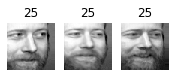

Cluster 94


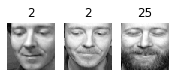

Cluster 95


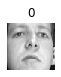

Cluster 96


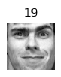

Cluster 97


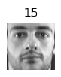

Cluster 98


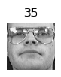

Cluster 99


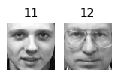

Cluster 100


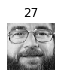

Cluster 101


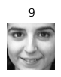

Cluster 102


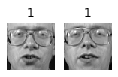

Cluster 103


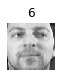

Cluster 104


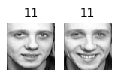

Cluster 105


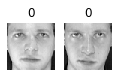

In [16]:
# visualise clusters
best_kmeans = KMeans(n_clusters=105, random_state=42).fit(X_train_pca)
visualise_clusters(best_kmeans, X_train, y_train)

Most of the cluster contains at least 2 images, but some of them seem to have only one image, or even contain 'intruders'.

We could use K-Means as pre-process to run a classification algorithm, such as RandomForest:

In [17]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=105, random_state=42)),
    ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
])
pipeline.fit(X_train_pca, y_train)
print(pipeline.score(X_valid_pca, y_valid))
print(pipeline.score(X_test_pca, y_test))

0.7875
0.85


### Gaussian Mixture

In [18]:
c_range = range(1, 15, 1)
gm_per_c = []
for c in c_range:
    gm = GaussianMixture(n_components=c).fit(X_train_pca)
    gm_per_c.append(gm)

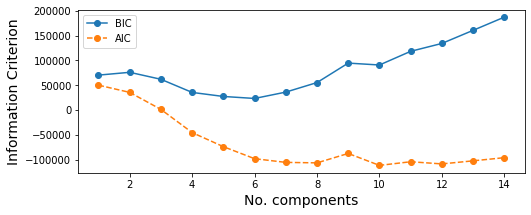

In [19]:
bics = [model.bic(X_train_pca) for model in gm_per_c]
aics = [model.aic(X_train_pca) for model in gm_per_c]
    
plt.figure(figsize=(8, 3))
plt.plot(c_range, bics, "o-", label="BIC")
plt.plot(c_range, aics, "o--", label="AIC")
plt.xlabel("No. components", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
# plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.legend()
plt.show()
    
    

The previous plot seems to suggest that 6 is a good choise as numebr of clusters

Cluster 1


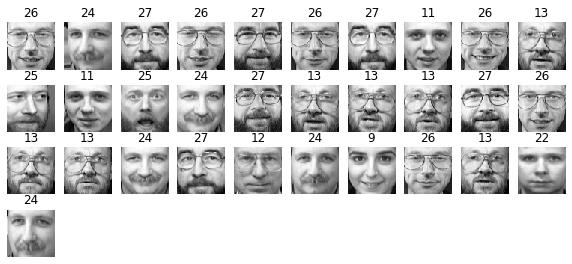

Cluster 2


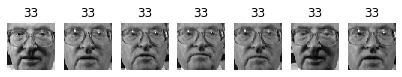

Cluster 3


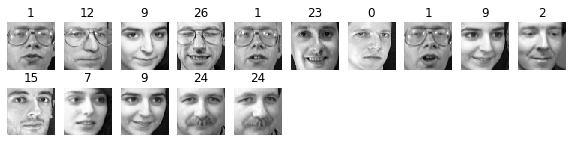

Cluster 4


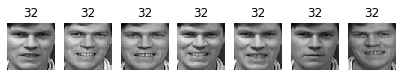

Cluster 5


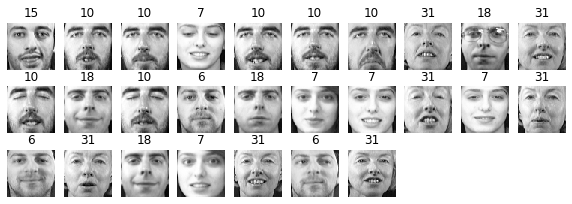

Cluster 6


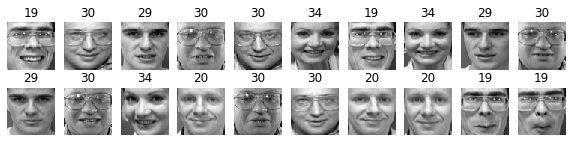

Cluster 7


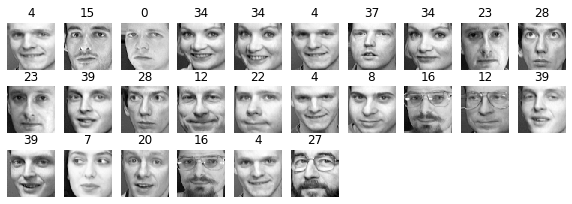

Cluster 8


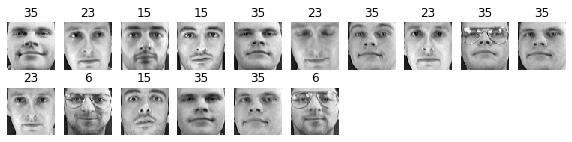

Cluster 9


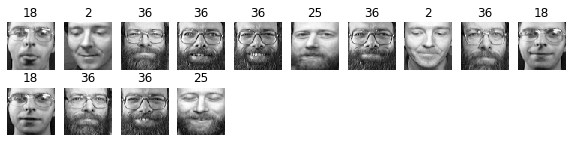

Cluster 10


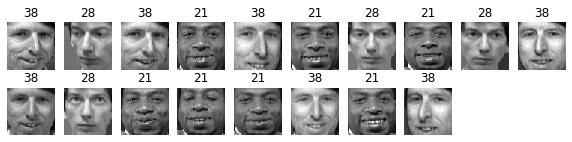

Cluster 11


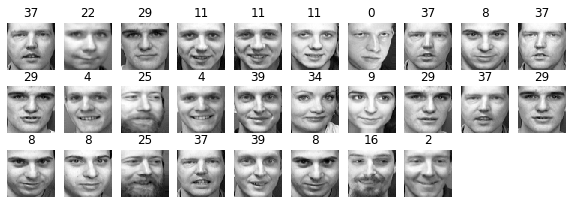

Cluster 12


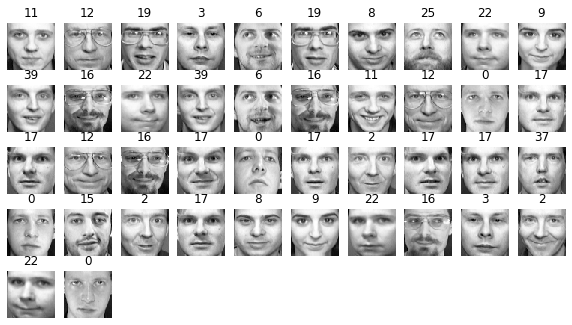

Cluster 13


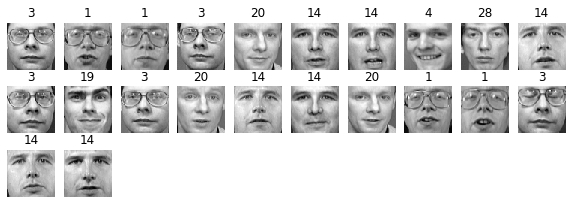

Cluster 14


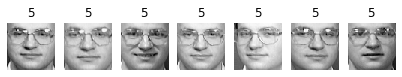

In [20]:
# visualise clusters
best_gm = GaussianMixture(n_components=6).fit(X_train_pca)
y_pred = gm.predict(X_train_pca)


for cl_id in np.unique(y_pred):
    print("Cluster "+str(cl_id+1))
    in_cluster_idxs = y_pred == cl_id
    images = X_train[in_cluster_idxs]
    labels = y_train[in_cluster_idxs]
    plot_images(images, labels)